In [1]:
# colab 에 Mecab name 'Tagger'is not defined 오류 없애기
# 참고 : https://sosomemo.tistory.com/31
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!echo ssac1234 | !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
! pip install pandas
! pip install Mecab
print("1")
! pip install Konlpy
import pandas as pd
import urllib.request
# % matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab


패키지 목록을 읽는 중입니다... 완료0%
E: 잠금 파일 /var/lib/apt/lists/lock 파일을 열 수 없습니다 - open (13: 허가 거부)
E: /var/lib/apt/lists/ 디렉터리를 잠글 수 없습니다
W: /var/cache/apt/pkgcache.bin 파일을 삭제하는데 문제가 있습니다 - RemoveCaches (13: 허가 거부)
W: /var/cache/apt/srcpkgcache.bin 파일을 삭제하는데 문제가 있습니다 - RemoveCaches (13: 허가 거부)
E: 잠금 파일 /var/lib/dpkg/lock-frontend 파일을 열 수 없습니다 - open (13: 허가 거부)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: !bash: 명령어를 찾을 수 없음
1


In [2]:
from konlpy.tag import Mecab

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    
    # 데이터의 중복 제거 및 NaN 결측치 제거
    train_data.drop_duplicates(subset = ['document'], inplace=True) 
    #subset은 중복데이터를 처리할 열을 입력, inplace는 메서드가 적용되는 원본 데이터를 변경할지 여부를 결정
    train_data = train_data.dropna(how ='any')
    # how = 'any' -> NA(결측치)값이 존재하면 그 행이나 열을 drop함.
    # 참고 : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
    test_data.drop_duplicates(subset = ['document'], inplace=True) 
    test_data = test_data.dropna(how ='any')
    
    # 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # Mecab의 morphs 기능을 통해 형태소로 구문분석
        # 참고 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/
        temp_X = [word for word in temp_X if not word in stopwords] 
        # 구분한 형태소 중 stopwords에 존재하지 않는 것만 temp_X에 저장
        X_train.append(temp_X)
    print("Xtrain",X_train)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    #?? concatenate는 배열을 붙이는 거라는 데 하나로 어떻게 합치지?
    # ndarray클래스이 tolist() 메소드를 이용해 list 객체를 구하여 words에 저장.
    words = np.concatenate(X_train).tolist() 
    # 리스트의 나온 횟수만큼 counter 리스트에 저장
    counter = Counter(words)
    # 데이터 개수가 많은 순으로 정렬된 배열을  리턴하는 most_common사용
    # 참고 : https://www.daleseo.com/python-collections-counter/
    counter = counter.most_common(10000-4)
    #사전에 정의되 있던 인덱스 + 문자열에서 추출한 문자를 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    
    # 리스트 컨프리헨션 사용헤서 사전 word_to_index구성
    # 참고 : https://wikidocs.net/16045
    word_to_index = {word:index for index, word in enumerate(vocab)}

    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
# 3. 모델 구성을 위한 데이터 분석 및 가공
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
#print('문장길이 평균 : ', np.mean(num_tokens))
#print('문장길이 최대 : ', np.max(num_tokens))
#print('문장길이 표준편차 : ', np.std(num_tokens))
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
#print('pad_sequences maxlen : ', maxlen)
#print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


In [6]:
# 4. 모델 구성 및 validation set 구성
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
# print(x_train.shape)

In [7]:
# 5. 모델 훈련 개시
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
# model.summary()
# validation set 10000건 분리
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train, partial_y_train, epochs=epochs,
                    batch_size=512, validation_data=(x_val, y_val), verbose=1)
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

(136182, 41)
(136182,)
Epoch 1/10
266/266 [==============================] - 4s 15ms/step - loss: 0.5522 - accuracy: 0.6989 - val_loss: 0.3871 - val_accuracy: 0.8391
Epoch 2/10
266/266 [==============================] - 4s 14ms/step - loss: 0.3533 - accuracy: 0.8534 - val_loss: 0.3518 - val_accuracy: 0.8496
Epoch 3/10
266/266 [==============================] - 4s 15ms/step - loss: 0.3246 - accuracy: 0.8648 - val_loss: 0.3424 - val_accuracy: 0.8522
Epoch 4/10
266/266 [==============================] - 4s 14ms/step - loss: 0.3109 - accuracy: 0.8710 - val_loss: 0.3441 - val_accuracy: 0.8489
Epoch 5/10
266/266 [==============================] - 4s 14ms/step - loss: 0.3024 - accuracy: 0.8742 - val_loss: 0.3429 - val_accuracy: 0.8507
Epoch 6/10
266/266 [==============================] - 4s 14ms/step - loss: 0.2961 - accuracy: 0.8764 - val_loss: 0.3572 - val_accuracy: 0.8449
Epoch 7/10
266/266 [==============================] - 4s 14ms/step - loss: 0.2871 - accuracy: 0.8797 - val_loss: 0.3476

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


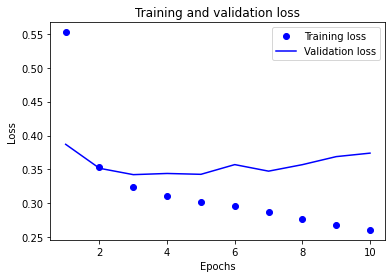

In [8]:
# 6. Loss, Accuracy 그래프 시각화
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
!pip install gensim
import os

In [10]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [11]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [12]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [13]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [15]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [16]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 21s 80ms/step - loss: 0.6133 - accuracy: 0.6333 - val_loss: 0.4319 - val_accuracy: 0.8041
Epoch 2/10
266/266 [==============================] - 21s 80ms/step - loss: 0.3831 - accuracy: 0.8315 - val_loss: 0.3651 - val_accuracy: 0.8409
Epoch 3/10
266/266 [==============================] - 20s 77ms/step - loss: 0.3351 - accuracy: 0.8569 - val_loss: 0.3470 - val_accuracy: 0.8491
Epoch 4/10
266/266 [==============================] - 20s 74ms/step - loss: 0.3137 - accuracy: 0.8680 - val_loss: 0.3517 - val_accuracy: 0.8484
Epoch 5/10
266/266 [==============================] - 20s 74ms/step - loss: 0.2938 - accuracy: 0.8778 - val_loss: 0.3552 - val_accuracy: 0.8456
Epoch 6/10
266/266 [==============================] - 20s 74ms/step - loss: 0.2756 - accuracy: 0.8874 - val_loss: 0.3559 - val_accuracy: 0.8470
Epoch 7/10
266/266 [==============================] - 20s 74ms/step - loss: 0.2595 - accuracy: 0.8951 - val_loss: 0.3624 - val_accuracy:

In [17]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4187 - accuracy: 0.8365
[0.41874992847442627, 0.8365441560745239]
